In [42]:
## Author: Peizhi Yan

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Image Shape (H, W, C):  (537, 550, 3)
[[146 147 147 145 145 145 145 144]
 [147 147 147 145 144 145 145 144]
 [146 146 146 145 144 145 145 144]
 [145 145 146 146 143 144 145 144]
 [145 145 146 145 143 144 144 144]
 [145 146 146 145 144 144 143 144]
 [145 146 146 145 145 145 144 144]
 [145 146 146 145 144 145 144 145]]


Text(0.5, 1.0, 'Original Image')

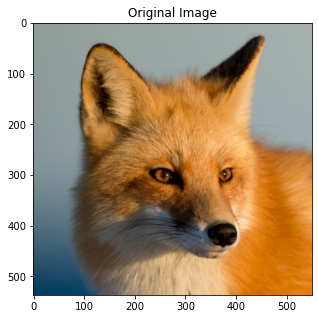

In [2]:
""" Load an Image """
img = cv2.imread('./data/fox.PNG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # re-order the channels
print("Image Shape (H, W, C): ", img.shape)
print(img[:8,:8,0]) # Print first 8x8 block of R channel

""" Show Original Image """
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title('Original Image')

Text(0.5, 1.0, 'V Channel')

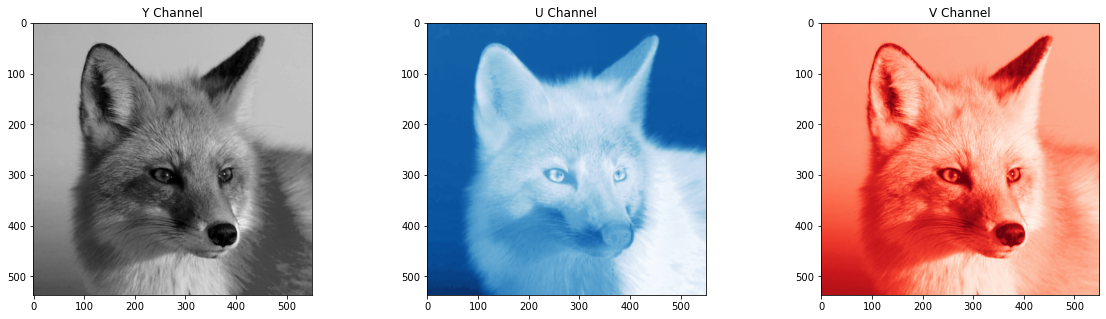

In [3]:
def rgb2yuv(X):
    """ Convert Image from RGB to YUV Color Space """
    P = np.array([[0.299000, 0.587000, 0.114000],
                  [-0.14713, -0.28886, 0.436000],
                  [0.615000, -0.51499, -0.100010]]) # Conversion matrix
    H = X.shape[0]
    W = X.shape[1]
    Y = np.reshape(X, (-1,3)) # Flatten the RGB image [H*W, 3]
    Z = np.matmul(Y, P) # Projection
    return np.reshape(Z, (H, W, 3)) # Reshape YUV image back to original size

def yuv2rgb(X):
    """ Convert Image from YUV to RGB Color Space """
    P = np.array([[1.0, 0.0     , 1.13983],
                  [1.0, -0.39465, -0.58060],
                  [1.0, 2.03211 , 0.0]]) # Conversion matrix
    H = X.shape[0]
    W = X.shape[1]
    Y = np.reshape(X, (-1,3)) # Flatten the YUV image [H*W, 3]
    Z = np.matmul(Y, P) # Projection
    return np.reshape(Z, (H, W, 3)) # Reshape RGB image back to original size

""" Convert the Original Image to YUV Color Space """
img_yuv = rgb2yuv(img)

# Following Lines Only for Visualization!!
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(np.array(img_yuv[:,:,0], dtype=int), cmap="gray")
plt.title('Y Channel')
plt.subplot(1,3,2)
plt.imshow(np.array(255-img_yuv[:,:,1], dtype=int), cmap="Blues")
plt.title('U Channel')
plt.subplot(1,3,3)
plt.imshow(np.array(255-img_yuv[:,:,2], dtype=int), cmap="Reds")
plt.title('V Channel')

# Discrete Cosine Transform Equation
N: block size

$\mathbf{F}$: DCT coefficient block

$\mathbf{f}$: image block

$$
\mathbf{F}(p,q) = \frac{C(p)}{\sqrt{N/2}} \frac{C(q)}{\sqrt{N/2}} \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} \mathbf{f}(i,j) \cos \frac{(2i+1)p\pi}{2N} \cos\frac{(2j+1)q\pi}{2N}\text{,}
$$
where $0 \le p, q < N$ and 
$$
    C(x) = \begin{cases} \frac{1}{\sqrt{2}} & x = 0 \\ 1 & x > 0 \end{cases}
$$

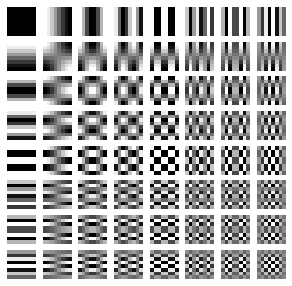

In [13]:
""" Generate 64 8x8 DCT Bases """
N = 8 # define the block size, here we use 8

DCT_bases = np.zeros([N, N, N, N])

# Compute the DCT bases
for p in range(N):
    for q in range(N):
        for i in range(N):
            for j in range(N):
                DCT_bases[p, q, i, j] = np.cos(((2*i + 1)*p*np.pi)/(2*N)) * np.cos(((2*j + 1)*q*np.pi)/(2*N))

# Display the DCT bases
plt.figure(figsize=(5,5))
for p in range(N):
    for q in range(N):
        plt.subplot(N,N,p*N+q+1)
        plt.imshow(DCT_bases[p,q], cmap='gray')
        plt.axis('off')


In [27]:
def _dct(f, N, DCT_bases):
    def C(x):
        if x > 0: return 1.0
        else: return 1.0/np.sqrt(2)
    """ Perform DCT on an Image Block """
    F = np.zeros([N,N])
    for p in range(N):
        for q in range(N):
            F[p, q] = (C(p)/np.sqrt(N/2)) * (C(q)/np.sqrt(N/2)) * np.dot(np.reshape(f, [-1]), 
                                                                         np.reshape(DCT_bases[p, q], [-1]))
    return F

# Inverse DCT Equation
$$
\mathbf{f}(i,j) = \sum_{p=0}^{N-1} \sum_{q=0}^{N-1} D(p) D(q) \mathbf{F}(p,q) \cos \frac{(2i+1)p\pi}{2N} \cos\frac{(2j+1)q\pi}{2N}\text{,}
$$
where $0 \le p, q < N$ and 
$$
    D(x) = \begin{cases} \frac{1}{\sqrt{N}} & x = 0 \\ \sqrt{\frac{2}{M}} & x > 0 \end{cases}
$$

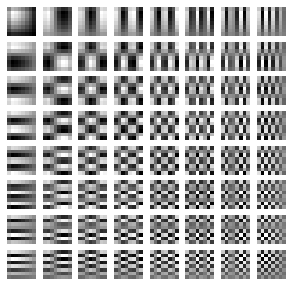

In [37]:
""" Generate 64 8x8 Inverse DCT Bases """

inv_DCT_bases = np.zeros([N, N, N, N])

def D(x):
    if x > 0: return np.sqrt(2/N)
    else: return 1.0/np.sqrt(N)
    
# Compute the inverse DCT bases
for i in range(N):
    for j in range(N):
        for p in range(N):
            for q in range(N):
                inv_DCT_bases[i, j, p, q] = D(p) * D(q) * np.cos(((2*i + 1)*p*np.pi)/(2*N)) * np.cos(((2*j + 1)*q*np.pi)/(2*N))

# Display the inverse DCT bases
plt.figure(figsize=(5,5))
for i in range(N):
    for j in range(N):
        plt.subplot(N,N,i*N+j+1)
        plt.imshow(inv_DCT_bases[i,j], cmap='gray')
        plt.axis('off')

In [38]:
def _inv_dct(F, N, inv_DCT_bases):
    """ Perform Inverse DCT on a Coefficient Block """
    f = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            f[i, j] = np.dot(np.reshape(F, [-1]), np.reshape(inv_DCT_bases[i, j], [-1]))
    return f

## Function for Processing Whole Image

In [62]:
def dct(img_y, N, DCT_bases):
    """ DCT """
    H = img_y.shape[0]
    W = img_y.shape[1]
    # add padding if necessary
    _H = H+(N-H%N) # height after padding
    _W = W+(N-W%N) # width after padding
    _img_y = np.zeros([_H, _W])
    _img_y[:H,:W] = img_y
    # DCT
    t_img_y = np.zeros([_H, _W])
    for i in range(_H//N):
        for j in range(_W//N):
            t_img_y[i*N:(i+1)*N, j*N:(j+1)*N] = _dct(_img_y[i*N:(i+1)*N, j*N:(j+1)*N], N, DCT_bases)
    return t_img_y[:H, :W]

def inv_dct(t_img_y, N, inv_DCT_bases):
    """ Inverse DCT """
    H = t_img_y.shape[0]
    W = t_img_y.shape[1]
    # add padding if necessary
    _H = H+(N-H%N) # height after padding
    _W = W+(N-W%N) # width after padding
    _t_img_y = np.zeros([_H, _W])
    _t_img_y[:H,:W] = t_img_y
    # inverse DCT
    img_y = np.zeros([_H, _W])
    for i in range(_H//N):
        for j in range(_W//N):
            img_y[i*N:(i+1)*N, j*N:(j+1)*N] = _inv_dct(_t_img_y[i*N:(i+1)*N, j*N:(j+1)*N], N, inv_DCT_bases)
    return img_y[:H, :W]

C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'DCT Coefficient Map')

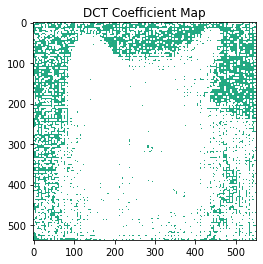

In [59]:
""" Transform the Y Channel of Original Image to DCT Domain """
coff_img_y = dct(img_yuv[:,:,0], N, DCT_bases)

plt.imshow(np.log1p(coff_img_y))
plt.title("DCT Coefficient Map")

Text(0.5, 1.0, 'Reconstructed Y Channel')

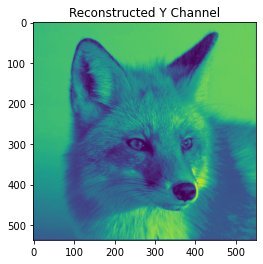

In [63]:
""" Use Inverse DCT to Get Reconstructed Y Channel """
rec_img_y = inv_dct(coff_img_y, N, inv_DCT_bases)

plt.imshow(np.array(rec_img_y, dtype=int))
plt.title("Reconstructed Y Channel")

# Demo of the Compression Ability of DCT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Image')

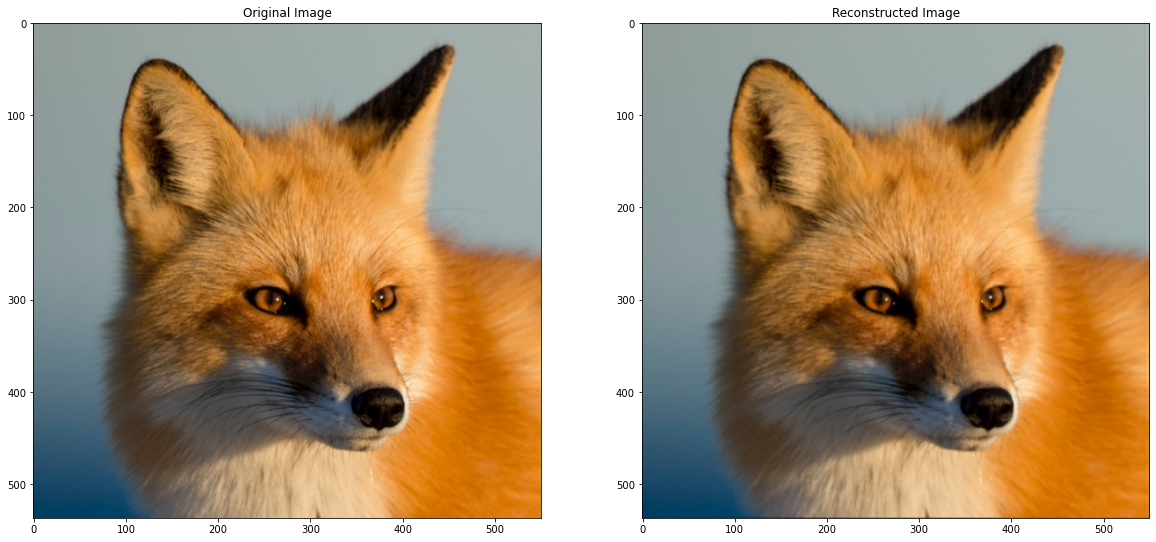

In [85]:
""" Transform the Y Channel of Original Image to DCT Domain """
coff_img_y = dct(img_yuv[:,:,0], N, DCT_bases)

""" Manually Remove Some High Frequency Information (here we just set them to zero) """
mask = np.array([[1,1,1,0,0,0,0,0],
                 [1,1,0,0,0,0,0,0],
                 [1,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0]]) # Only keeps 6 values for each 8x8 block
H = coff_img_y.shape[0]
W = coff_img_y.shape[1]
# add padding if necessary
_H = H+(N-H%N) # height after padding
_W = W+(N-W%N) # width after padding
_coff_img_y = np.zeros([_H, _W])
_coff_img_y[:H,:W] = coff_img_y
for i in range(_H//N):
    for j in range(_W//N):
        _coff_img_y[i*N:(i+1)*N, j*N:(j+1)*N] = np.multiply(_coff_img_y[i*N:(i+1)*N, j*N:(j+1)*N], mask)
_coff_img_y = _coff_img_y[:H,:W]

""" Use Inverse DCT to Get Reconstructed Y Channel """
rec_img_y = inv_dct(_coff_img_y, N, inv_DCT_bases)

""" Stack with U and V Channel to Get Reconstructed Image """
rec_img = np.zeros([H, W, 3])
rec_img_y = np.clip(rec_img_y, a_min=0, a_max=255)
rec_img[:,:,0] = rec_img_y
rec_img[:,:,1] = img_yuv[:,:,1]
rec_img[:,:,2] = img_yuv[:,:,2]
rec_img = yuv2rgb(rec_img) # convert back to RGB space
rec_img = np.array(rec_img, dtype=int) # value quantization

""" Compare """
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(rec_img)
plt.title('Reconstructed Image')

Text(0.5, 1.0, 'Reconstructed Y Channel')

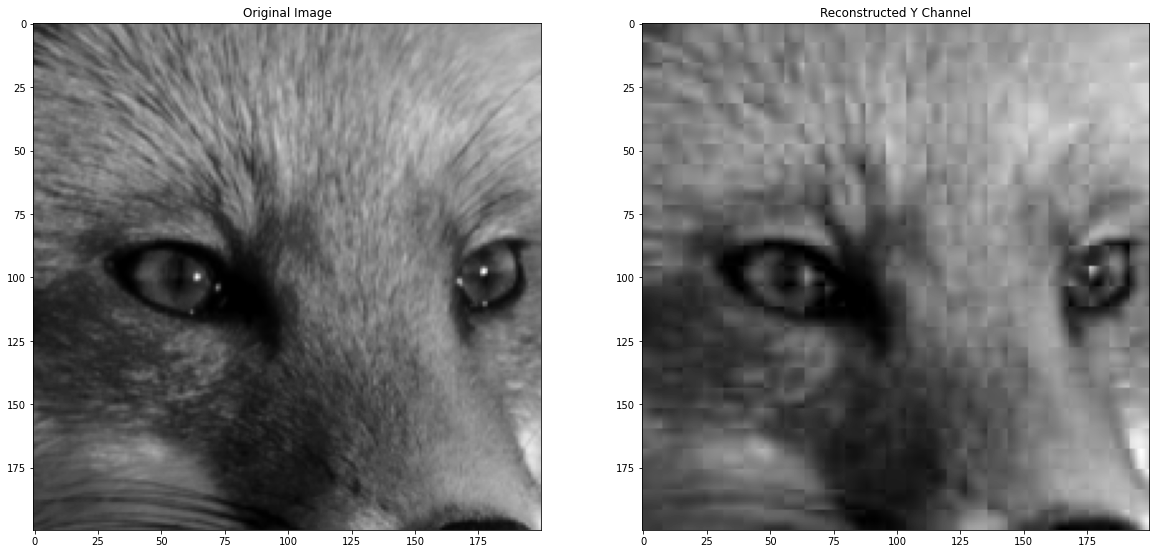

In [87]:
""" Only Compare Y Channel """
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_yuv[200:400, 200:400, 0], cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(rec_img_y[200:400, 200:400], cmap='gray')
plt.title('Reconstructed Y Channel')